# 1D NLSE Solver

The goal of this notebook is to solve the Nonlinear Shrodinger Equation in 1D:
\begin{equation}
    \frac{\partial A}{\partial z} = -i\frac{\beta_2}{2} \frac{\partial^2 A}{\partial t^2} + i\gamma |A|^2 A.
\end{equation}
The first term of RHS corresponds to the chromatic dispersion, where $\beta_2$ is group velocity dispersion, and the second term is Kerr nonlinearity. 

This can be solved numerically using split-step Fourier method:
\begin{equation}
    A(z + \Delta z, T) = \mathcal{F}^{-1}\left\{ e^{i\frac{\beta_2}{2} (\omega)^2 \Delta z}  \cdot   \mathcal{F} \left\{   e^{i \gamma |A(z, T)|^2 \Delta z}   A(z, T) \right\}  \right\} 
\end{equation}

In [40]:
# general imports
import numpy as np
import matplotlib.pyplot as plt
import os


# torch imports
import torch
import torch.nn.functional as F
import torch.optim as optim

# import module
from nlse import *

## Idea 1: Add Smoothing Loss Term

### Optimizing $A(0, t)$

Fundamental soliton pulse has the sech shape
\begin{equation}
    A_s(z,t) = A_0 sech( \frac{t}{T_0} ) e^{-i\frac{\beta_2}{2T_0^2} z}.
\end{equation}

This is the "optimal" pulse for the given medium which we will try to find using PyTorch.

### Define Parameters

In [37]:
# define simulation parameters
Lz = 20.0               # Propagation distance in km
Nz = 100              # Number of steps in z
dz = Lz / Nz            # Step size in z
Lt = 300              # Temporal window size
Nt = 1024               # Number of temporal points

# define the training parameters
N_train = 1000
lr = 5e-4
w_mse = 1.0
w_smooth = 1.0

# define medium parameters
beta2 = -20           # Dispersion coefficient in ps^2/km
gamma = 20


### Define Initial Guess

In [38]:
def gaussian_pulse(t, center, T0, P0):
    """Generate a Gaussian pulse using PyTorch."""
    return torch.sqrt(torch.tensor(P0)) * torch.exp(-((t - center) ** 2) / (2 * T0 ** 2))

# set Gaussian parameters
center = Lt / 2         # Center of the Gaussian pulse
T0 = 10.0             # Width of the Gaussian pulse on ps
P0 = 0.007                # sqrt of the peak power of the Gaussian pulse

# independent variable (we use torch for automatic differentiation)
t = torch.linspace(0, Lt, Nt)  # Temporal grid (only positive times)

Ain = torch.nn.Parameter(gaussian_pulse(t, center, T0, P0).clone().detach().requires_grad_(True))

### Define Model and Loss Function

In [17]:
def forward(Ain):
    # Perform the split-step Fourier method
    A_evolution = split_step_fourier(Ain, dz, Nz, beta2, gamma, Lt)
    return A_evolution[:, -1]

def loss_function(Ain, Aout):
    # return the mean squared error
    mse_loss = F.mse_loss(torch.abs(Ain)**2, torch.abs(Aout)**2)
    smoothing_loss = time_derivative_fft(Ain, Nt, Lt).pow(2).mean()
    
    return w_mse * mse_loss + w_smooth * smoothing_loss

optimizer = optim.Adam([Ain], lr=lr)

### Train Model

In [18]:
losses = []


# Training loop
for iter in range(N_train):
    # clear gradients from previous step
    optimizer.zero_grad()  

    Aout = forward(Ain)  # full forward pass
    
    loss = loss_function(Ain, Aout)  # calculate the loss

    # backpropagate the loss
    loss.backward()
    
    # update the parameters
    optimizer.step()

    # save and print the loss every 100 iteration
    if iter % 10 == 0:
        losses.append(loss.item())
        if iter % 50 == 0:
            print(f"Iteration {iter}, Loss: {loss.item()}")

Iteration 0, Loss: 2.730786036408972e-06
Iteration 50, Loss: 3.1902361570246285e-06
Iteration 100, Loss: 3.4856564070651075e-06
Iteration 150, Loss: 4.4619864638661966e-06
Iteration 200, Loss: 5.498629434441682e-06
Iteration 250, Loss: 6.505008968815673e-06
Iteration 300, Loss: 7.374624146905262e-06
Iteration 350, Loss: 8.081244232016616e-06
Iteration 400, Loss: 8.675533536006697e-06
Iteration 450, Loss: 9.215229511028156e-06
Iteration 500, Loss: 9.729230441735126e-06
Iteration 550, Loss: 1.0222817763860803e-05
Iteration 600, Loss: 1.0695196579035837e-05
Iteration 650, Loss: 1.1150213140354026e-05
Iteration 700, Loss: 1.1597196134971455e-05
Iteration 750, Loss: 1.2047446944052354e-05
Iteration 800, Loss: 1.251128014700953e-05
Iteration 850, Loss: 1.2996344594284892e-05
Iteration 900, Loss: 1.3507235053111799e-05
Iteration 950, Loss: 1.404603426635731e-05


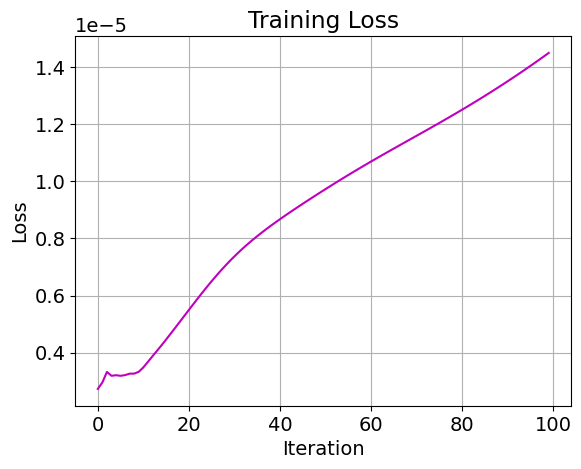

In [19]:
# plot the loss
plt.plot(losses, color='m')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid()
plt.show()

### View Results

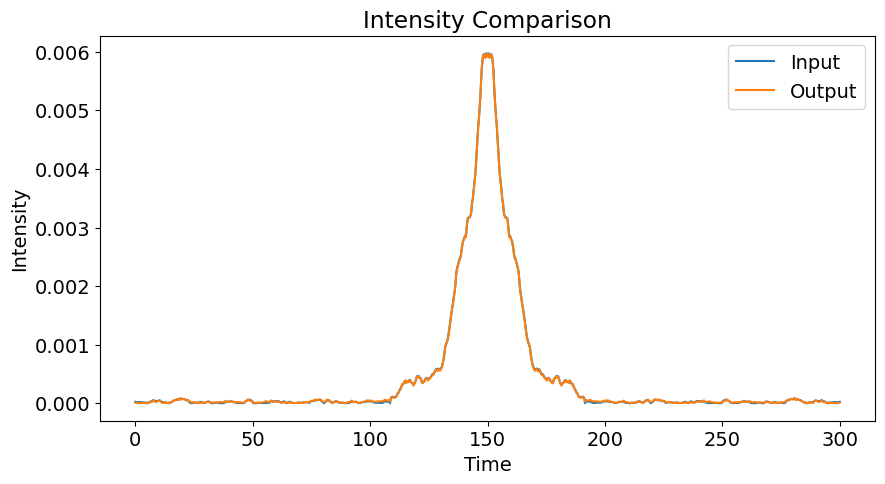

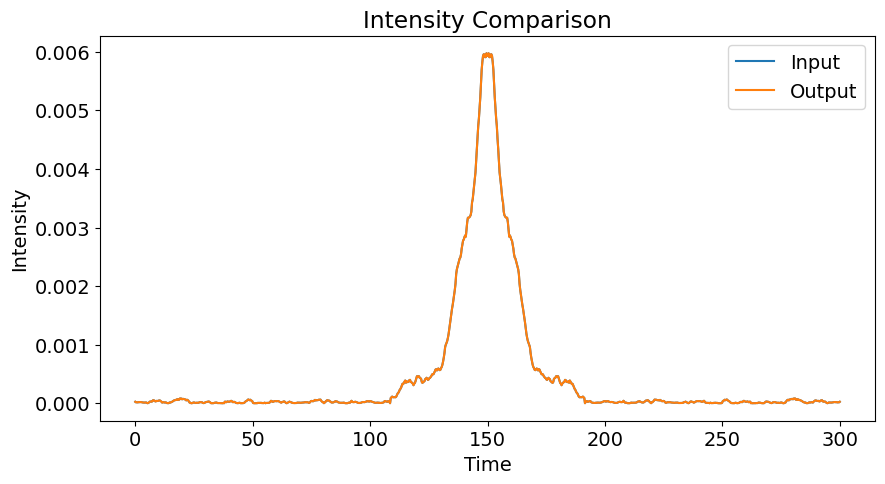

c:\Users\lukas\anaconda3\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


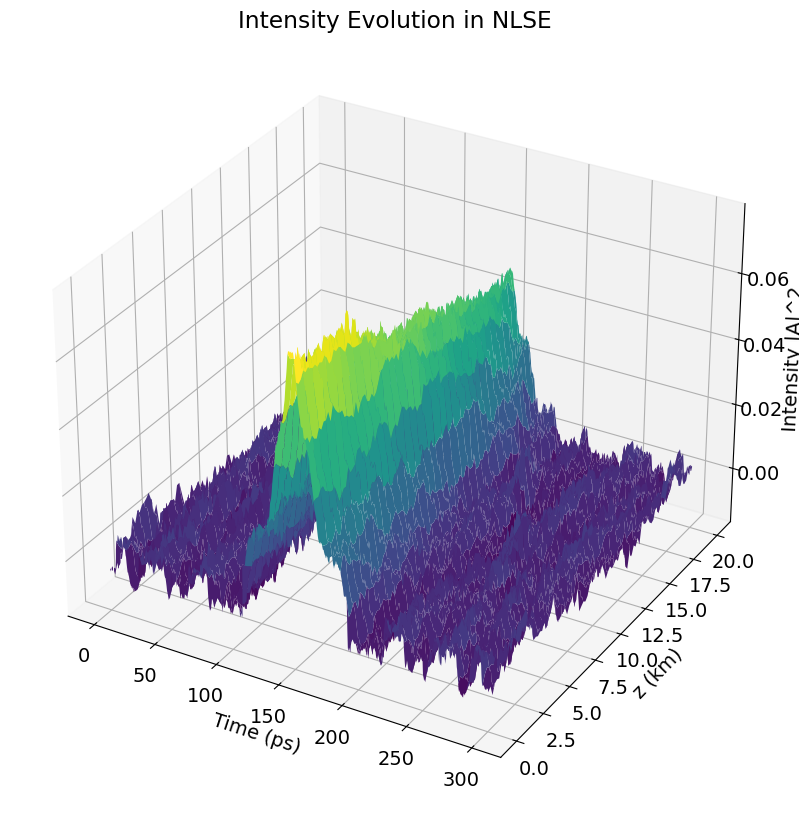

In [ ]:
# plot comparison between input and output
plot_intensity_comparison(Ain, Aout, t)
# plot 3D evolution
A_evolution = split_step_fourier(Ain, dz, Nz, beta2, gamma, Lt)
plot_intensity_evolution(A_evolution, t, Lz, Nz)

## Idea 2: Match FT also

### Define Parameters

In [29]:
# define simulation parameters
Lz = 20.0               # Propagation distance in km
Nz = 100              # Number of steps in z
dz = Lz / Nz            # Step size in z
Lt = 300              # Temporal window size
Nt = 1024               # Number of temporal points

# define the training parameters
N_train = 1000
lr = 1e-4
w_mse = 1.0
w_mse_ft = 1.0

# define medium parameters
beta2 = -20           # Dispersion coefficient in ps^2/km
gamma = 20


### Define Initial Guess

In [30]:
def gaussian_pulse(t, center, T0, P0):
    """Generate a Gaussian pulse using PyTorch."""
    return torch.sqrt(torch.tensor(P0)) * torch.exp(-((t - center) ** 2) / (2 * T0 ** 2))

# set Gaussian parameters
center = Lt / 2         # Center of the Gaussian pulse
T0 = 10.0             # Width of the Gaussian pulse on ps
P0 = 0.007                # sqrt of the peak power of the Gaussian pulse

# independent variable (we use torch for automatic differentiation)
t = torch.linspace(0, Lt, Nt)  # Temporal grid (only positive times)

Ain = torch.nn.Parameter(gaussian_pulse(t, center, T0, P0).clone().detach().requires_grad_(True))

### Define Model and Loss Function

In [33]:
def forward(Ain):
    # Perform the split-step Fourier method
    A_evolution = split_step_fourier(Ain, dz, Nz, beta2, gamma, Lt)
    return A_evolution[:, -1]

def loss_function(Ain, Aout):
    # return the mean squared error
    mse_loss = F.mse_loss(torch.abs(Ain)**2, torch.abs(Aout)**2)
    mse_ft_loss = F.mse_loss(torch.abs(torch.fft.fftshift(torch.fft.fft(Ain))), torch.abs(torch.fft.fftshift(torch.fft.fft(Aout))))
    
    return w_mse * mse_loss + w_mse_ft * mse_ft_loss

optimizer = optim.Adam([Ain], lr=lr)

### Train Model

In [34]:
losses = []


# Training loop
for iter in range(N_train):
    # clear gradients from previous step
    optimizer.zero_grad()  

    Aout = forward(Ain)  # full forward pass
    
    loss = loss_function(Ain, Aout)  # calculate the loss

    # backpropagate the loss
    loss.backward()
    
    # update the parameters
    optimizer.step()

    # save and print the loss every 100 iteration
    if iter % 10 == 0:
        losses.append(loss.item())
        if iter % 50 == 0:
            print(f"Iteration {iter}, Loss: {loss.item()}")

Iteration 0, Loss: 0.043667711317539215
Iteration 50, Loss: 0.01562616042792797
Iteration 100, Loss: 0.007328769192099571
Iteration 150, Loss: 0.004549849778413773
Iteration 200, Loss: 0.0031103261280804873
Iteration 250, Loss: 0.0022189326118677855
Iteration 300, Loss: 0.0016319890273734927
Iteration 350, Loss: 0.0012341125402599573
Iteration 400, Loss: 0.0009581394260749221
Iteration 450, Loss: 0.0007565085543319583
Iteration 500, Loss: 0.0006071190000511706
Iteration 550, Loss: 0.0004947360139340162
Iteration 600, Loss: 0.0004152092442382127
Iteration 650, Loss: 0.00035646127071231604
Iteration 700, Loss: 0.00030714122112840414
Iteration 750, Loss: 0.0002633834374137223
Iteration 800, Loss: 0.00022087793331593275
Iteration 850, Loss: 0.0001781004830263555
Iteration 900, Loss: 0.0001324598561041057
Iteration 950, Loss: 8.707302185939625e-05


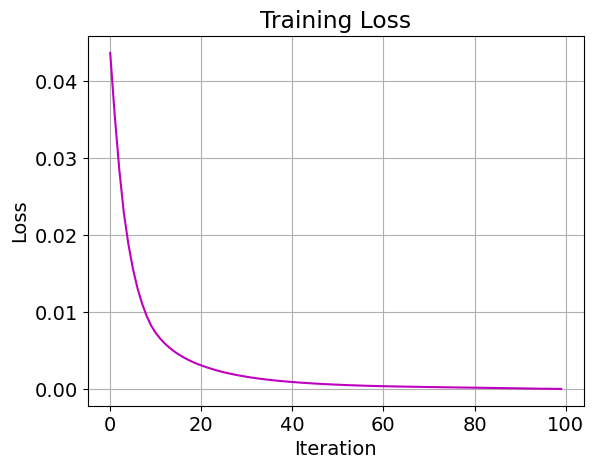

In [35]:
# plot the loss
plt.plot(losses, color='m')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid()
plt.show()

### View Results

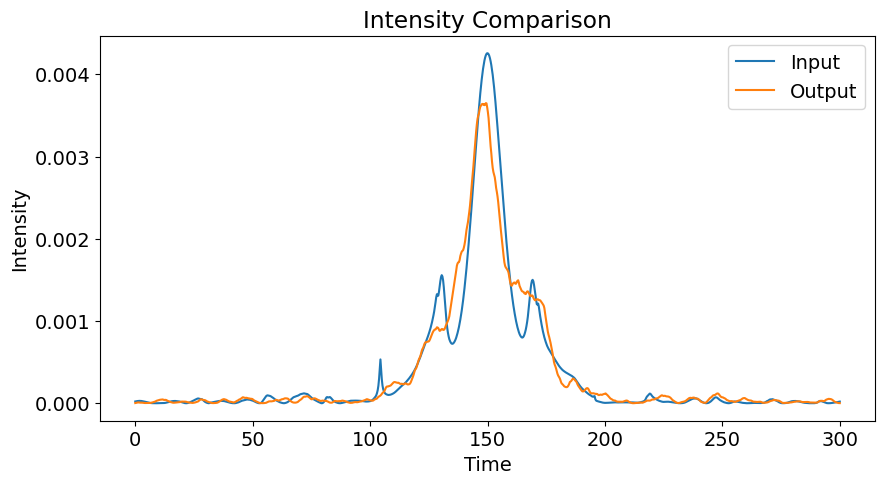

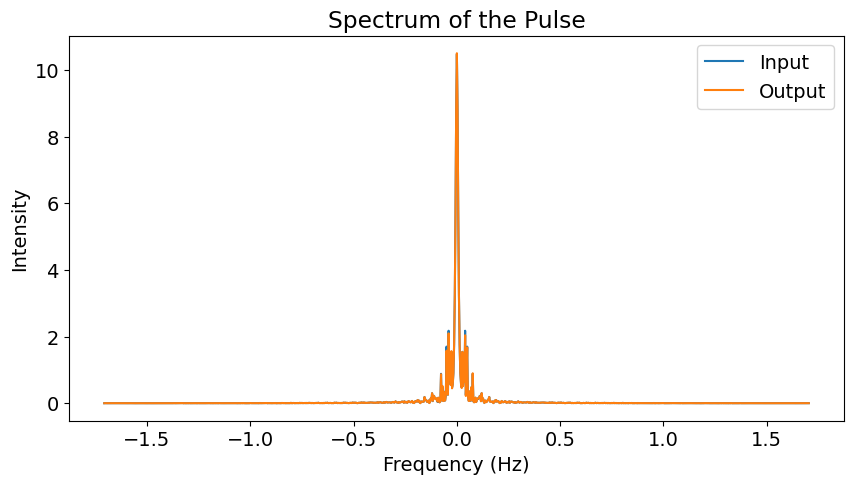

c:\Users\lukas\anaconda3\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


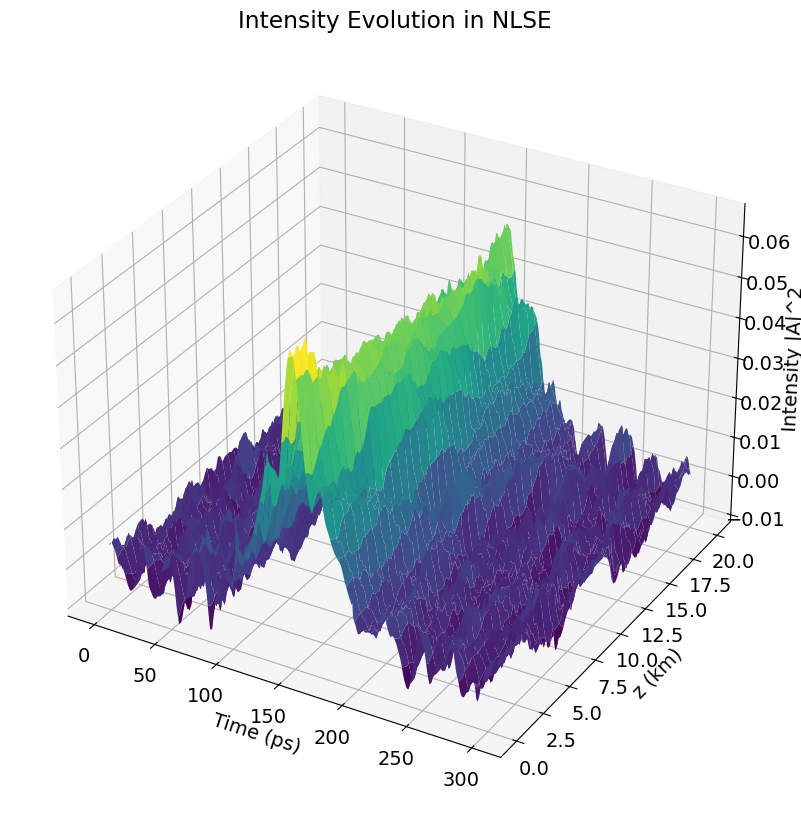

In [38]:
# plot comparison between input and output
plot_intensity_comparison(Ain, Aout, t)

# plot ft comparison between input and output
plot_spectrum_comparison(Ain, Aout, Nt, Lt)

# plot 3D evolution
A_evolution = split_step_fourier(Ain, dz, Nz, beta2, gamma, Lt)
plot_intensity_evolution(A_evolution, t, Lz, Nz)

## Idea 3: Look at Evolution Throughout

### Optimizing $A(0, t)$

Fundamental soliton pulse has the sech shape
\begin{equation}
    A_s(z,t) = A_0 sech( \frac{t}{T_0} ) e^{-i\frac{\beta_2}{2T_0^2} z}.
\end{equation}

This is the "optimal" pulse for the given medium which we will try to find using PyTorch.

### Define Parameters

In [2]:
# define simulation parameters
Lz = 20.0               # Propagation distance in km
Nz = 100              # Number of steps in z
dz = Lz / Nz            # Step size in z
Lt = 300              # Temporal window size
Nt = 1024               # Number of temporal points

# define the training parameters
N_train = 500
lr = 1e-3
w_mse = 1.0
w_smooth = 1.0

# define model parameters
m = 8 # how many snapshots to compare

# define medium parameters
beta2 = -20           # Dispersion coefficient in ps^2/km
gamma = 20


### Define Initial Guess

In [3]:
def gaussian_pulse(t, center, T0, P0):
    """Generate a Gaussian pulse using PyTorch."""
    return torch.sqrt(torch.tensor(P0)) * torch.exp(-((t - center) ** 2) / (2 * T0 ** 2))

# set Gaussian parameters
center = Lt / 2         # Center of the Gaussian pulse
T0 = 10.0             # Width of the Gaussian pulse on ps
P0 = 0.007                # sqrt of the peak power of the Gaussian pulse

# independent variable (we use torch for automatic differentiation)
t = torch.linspace(0, Lt, Nt)  # Temporal grid (only positive times)

Ain = torch.nn.Parameter(gaussian_pulse(t, center, T0, P0).clone().detach().requires_grad_(True))

### Define Model and Loss Function

In [4]:
def forward(Ain):
    # Perform the split-step Fourier method
    A_evolution = split_step_fourier(Ain, dz, Nz, beta2, gamma, Lt)
    iters = np.linspace(0, Nz-1, m).astype(int)
    return A_evolution[:, iters]

def loss_function(Ain, Aev):
    # for each column in Aev (of m columns), calculate the mse with the last column
    mse_loss = 0
    for i in range(m):
        mse_loss += F.mse_loss(torch.abs(Aev[:, i])**2, torch.abs(Aev[:, -1])**2)
    return mse_loss
    
    # # for each column in Aev (of m columns), calculate the mse with the previous column
    # mse_loss = 0
    # for i in range(1, m):
    #     mse_loss += F.mse_loss(torch.abs(Aev[:, i])**2, torch.abs(Aev[:, i-1])**2)
    # return mse_loss
    

optimizer = optim.Adam([Ain], lr=lr)

In [5]:
print(np.linspace(0, Nz-1, m).astype(int))

[ 0 14 28 42 56 70 84 99]


### Train Model

In [6]:
losses = []


# Training loop
for iter in range(N_train):
    # clear gradients from previous step
    optimizer.zero_grad()  

    Aev = forward(Ain)  # full forward pass
    
    loss = loss_function(Ain, Aev)  # calculate the loss

    # backpropagate the loss
    loss.backward()
    
    # update the parameters
    optimizer.step()

    # save and print the loss every 100 iteration
    if iter % 10 == 0:
        losses.append(loss.item())
        if iter % 50 == 0:
            print(f"Iteration {iter}, Loss: {loss.item()}")

Iteration 0, Loss: 1.960142071766313e-06
Iteration 50, Loss: 1.7751693448531114e-08
Iteration 100, Loss: 4.148223986533139e-09
Iteration 150, Loss: 1.911871105875207e-09
Iteration 200, Loss: 1.096069901507235e-09
Iteration 250, Loss: 6.722777334822183e-10
Iteration 300, Loss: 4.2978870462562213e-10
Iteration 350, Loss: 2.9316069016793733e-10
Iteration 400, Loss: 2.1608076439250112e-10
Iteration 450, Loss: 1.7034471055943357e-10


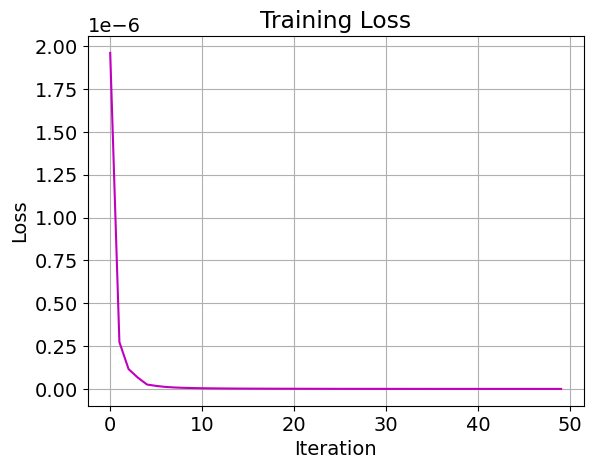

In [7]:
# plot the loss
plt.plot(losses, color='m')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid()
plt.show()

### View Results

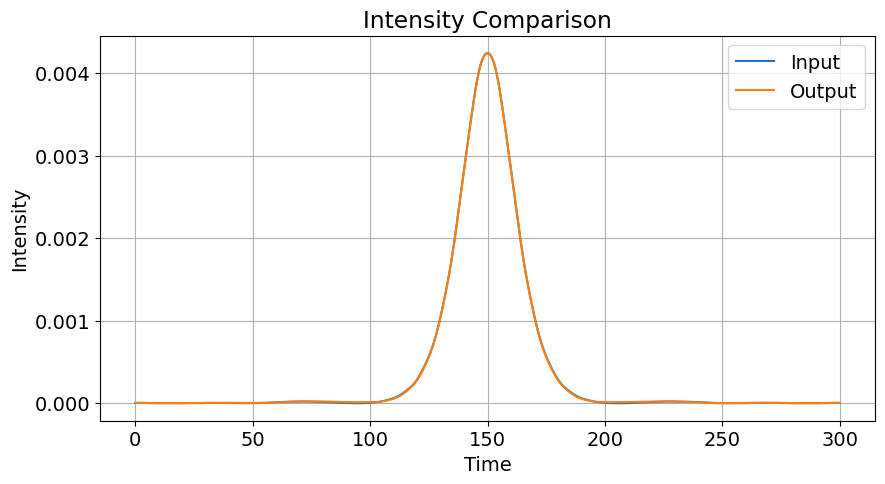

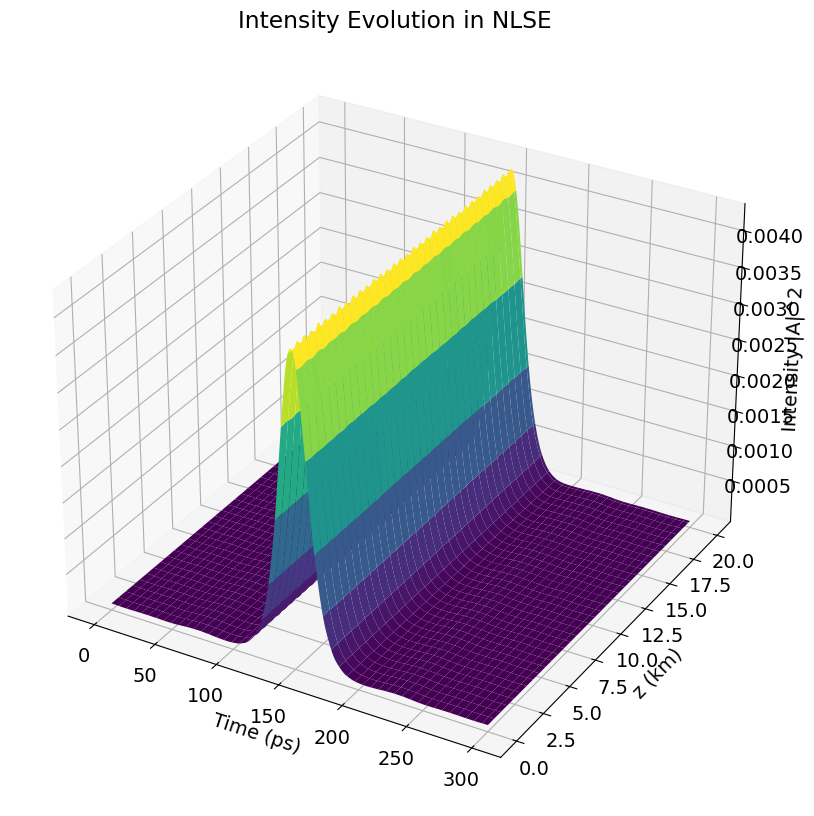

In [8]:
Aout = Aev[:, -1]
# plot comparison between input and output
plot_intensity_comparison(Ain, Aout, t)
# plot 3D evolution
A_evolution = split_step_fourier(Ain, dz, Nz, beta2, gamma, Lt)
plot_intensity_evolution(A_evolution, t, Lz, Nz)

## Optimization 1: Constrain Wavefunction by Masking

### Define Parameters

In [9]:
# define simulation parameters
Lz = 20.0               # Propagation distance in km
Nz = 100              # Number of steps in z
dz = Lz / Nz            # Step size in z
Lt = 300              # Temporal window size
Nt = 1024               # Number of temporal points

# define the training parameters
N_train = 1000
lr = 1e-3
w_mse = 1.0
w_smooth = 1.0

# define model parameters
m = 8 # how many snapshots to compare
mask_percent = 0.25 # mask percentage

# define medium parameters
beta2 = -20           # Dispersion coefficient in ps^2/km
gamma = 20


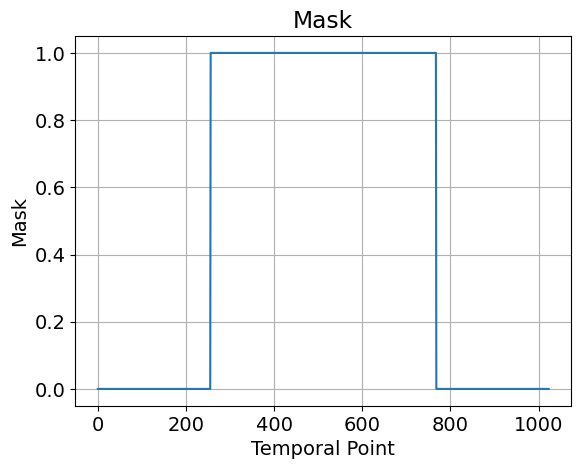

In [10]:
# set mask
mask = torch.zeros(Nt)
mask_cutoff = int(Nt * mask_percent)
mask[mask_cutoff:-mask_cutoff] = 1

# plot the mask
plt.plot(mask)
plt.xlabel('Temporal Point')
plt.ylabel('Mask')
plt.title('Mask')
plt.grid()
plt.show()


### Define Initial Guess

In [11]:
def gaussian_pulse(t, center, T0, P0):
    """Generate a Gaussian pulse using PyTorch."""
    return torch.sqrt(torch.tensor(P0)) * torch.exp(-((t - center) ** 2) / (2 * T0 ** 2))

# set Gaussian parameters
center = Lt / 2         # Center of the Gaussian pulse
T0 = 10.0             # Width of the Gaussian pulse on ps
P0 = 0.007                # sqrt of the peak power of the Gaussian pulse

# independent variable (we use torch for automatic differentiation)
t = torch.linspace(0, Lt, Nt)  # Temporal grid (only positive times)

Ain = torch.nn.Parameter(gaussian_pulse(t, center, T0, P0).clone().detach().requires_grad_(True)*mask)

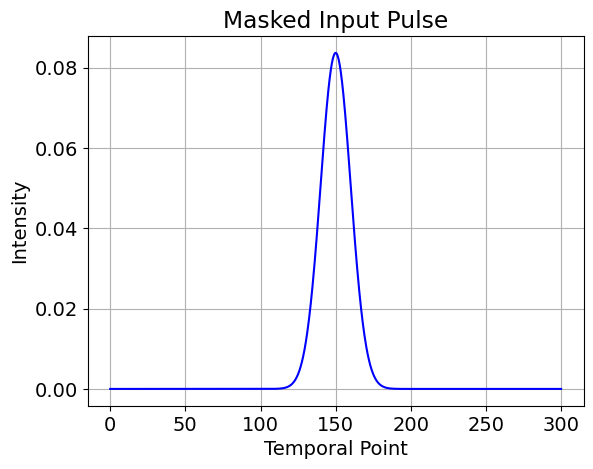

In [12]:
# plot the masked pulse
plt.plot(t, Ain.detach().numpy(), color='b')
plt.xlabel('Temporal Point')
plt.ylabel('Intensity')
plt.title('Masked Input Pulse')
plt.grid()
plt.show()

### Define Model and Loss Function

In [13]:
def forward(Ain):
    # apply mask
    Ain = Ain * mask
    # Perform the split-step Fourier method
    A_evolution = split_step_fourier(Ain, dz, Nz, beta2, gamma, Lt)
    iters = np.linspace(0, Nz-1, m).astype(int)
    return A_evolution[:, iters]

def loss_function(Ain, Aev):
    # for each column in Aev (of m columns), calculate the mse with the last column
    mse_loss = 0
    for i in range(m):
        mse_loss += F.mse_loss(torch.abs(Aev[:, i])**2, torch.abs(Aev[:, -1])**2)
    return mse_loss
    
    # # for each column in Aev (of m columns), calculate the mse with the previous column
    # mse_loss = 0
    # for i in range(1, m):
    #     mse_loss += F.mse_loss(torch.abs(Aev[:, i])**2, torch.abs(Aev[:, i-1])**2)
    # return mse_loss
    

optimizer = optim.Adam([Ain], lr=lr)

### Train Model

In [14]:
losses = []


# Training loop
for iter in range(N_train):
    # clear gradients from previous step
    optimizer.zero_grad()  

    Aev = forward(Ain)  # full forward pass
    
    loss = loss_function(Ain, Aev)  # calculate the loss

    # backpropagate the loss
    loss.backward()
    
    # update the parameters
    optimizer.step()

    # save and print the loss every 100 iteration
    if iter % 10 == 0:
        losses.append(loss.item())
        if iter % 50 == 0:
            print(f"Iteration {iter}, Loss: {loss.item()}")

Iteration 0, Loss: 1.960142071766313e-06
Iteration 50, Loss: 1.9876981838251595e-08
Iteration 100, Loss: 6.349951675588272e-09
Iteration 150, Loss: 3.4789267022716786e-09
Iteration 200, Loss: 1.6681352965619567e-09
Iteration 250, Loss: 6.625500148516039e-10
Iteration 300, Loss: 2.1981418074634718e-10
Iteration 350, Loss: 7.062566503845957e-11
Iteration 400, Loss: 3.198934866999181e-11
Iteration 450, Loss: 2.407840246632098e-11
Iteration 500, Loss: 2.275449273447805e-11
Iteration 550, Loss: 2.2566695040415752e-11
Iteration 600, Loss: 2.2544771605126357e-11
Iteration 650, Loss: 2.2536269725370595e-11
Iteration 700, Loss: 2.2536385951843485e-11
Iteration 750, Loss: 2.2529995230557986e-11
Iteration 800, Loss: 2.252697160753936e-11
Iteration 850, Loss: 2.2520735276643222e-11
Iteration 900, Loss: 2.2521290388155535e-11
Iteration 950, Loss: 2.2515189365690524e-11


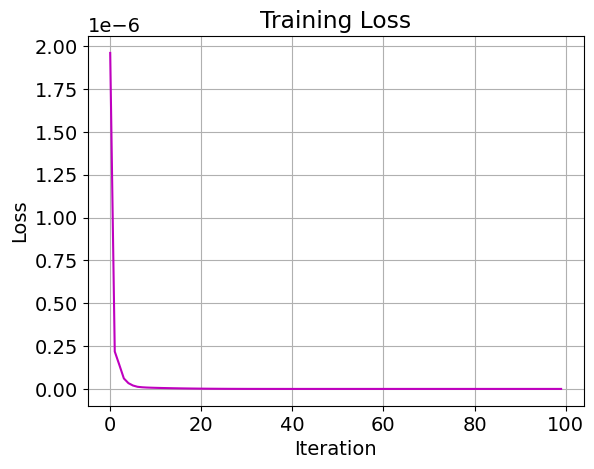

In [15]:
# plot the loss
plt.plot(losses, color='m')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid()
plt.show()

### View Results

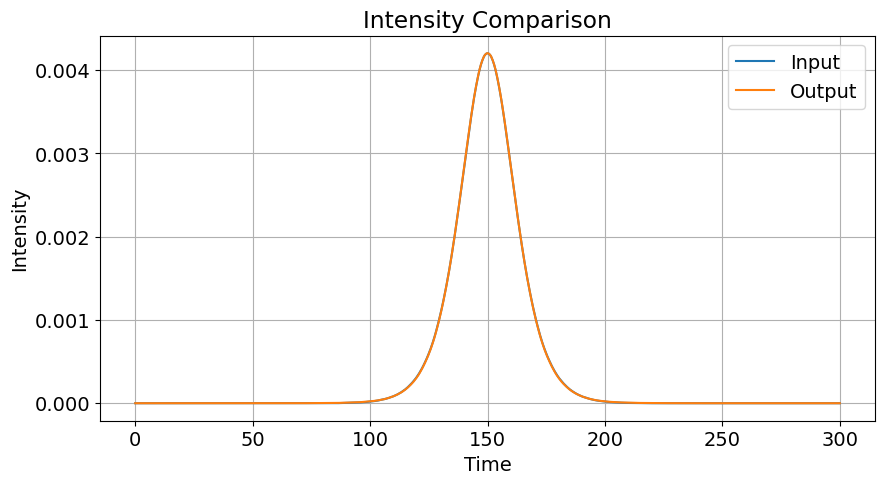

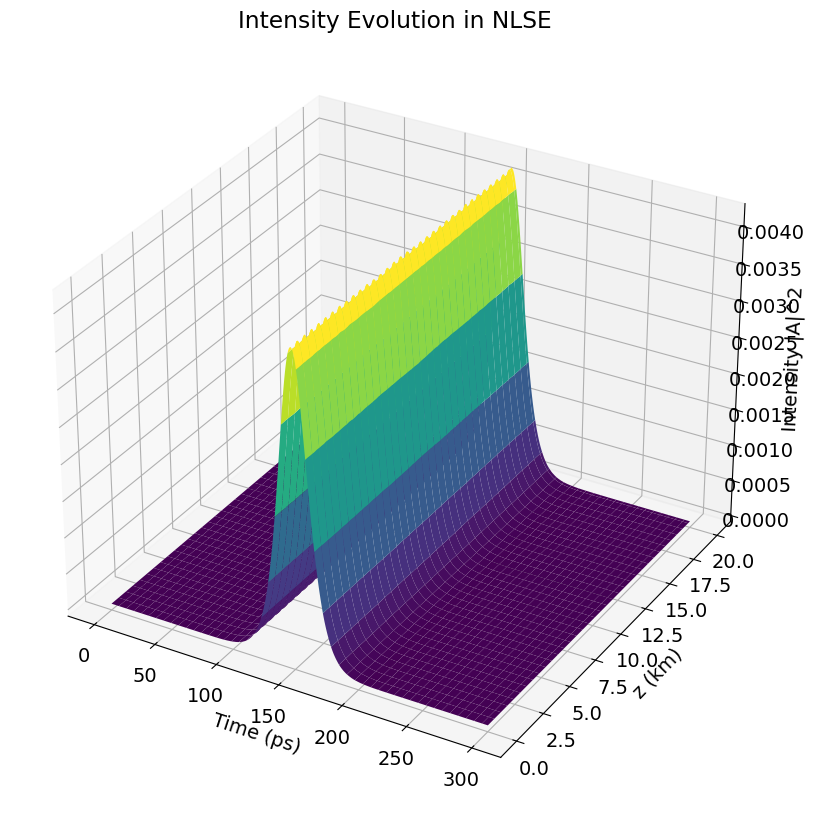

In [16]:
Aout = Aev[:, -1]
Ain_masked = Ain * mask
# plot comparison between input and output
plot_intensity_comparison(Ain_masked, Aout, t)
# plot 3D evolution
A_evolution = split_step_fourier(Ain_masked, dz, Nz, beta2, gamma, Lt)
plot_intensity_evolution(A_evolution, t, Lz, Nz)

## Optimization 2: Constrain Wavefunction by Energy
Constraining the energy of the pulse i.e. setting it to a specific value $E_{target}$ essentially eliminates 1 degree of freedom for the pulse and can help comapre the pulse to other standardized energy pulses.

### Define Parameters

In [13]:
# define simulation parameters
Lz = 20.0               # Propagation distance in km
Nz = 100              # Number of steps in z
dz = Lz / Nz            # Step size in z
Lt = 300              # Temporal window size
Nt = 1024               # Number of temporal points

# define the training parameters
N_train = 500
lr = 1e-3
w_mse = 1.0
w_energy = 0.0001 # similar order of magnitude with this weight

# define model parameters and constraint
m = 3 # how many snapshots to compare
mask_percent = 0.25 # mask percentage
E_target = 0.20 # define the target energy (value determined based on a known reference pulse)

# define medium parameters
beta2 = -20           # Dispersion coefficient in ps^2/km
gamma = 20


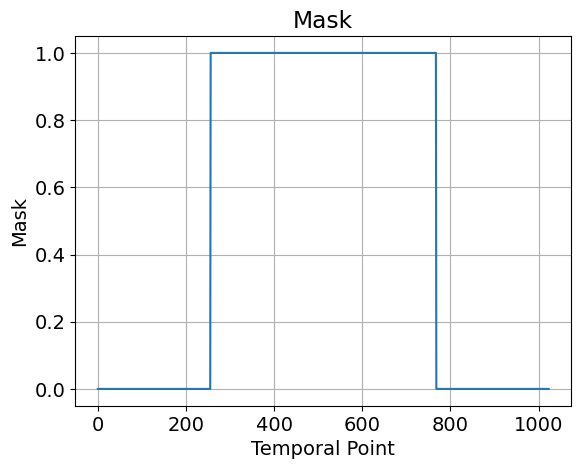

In [14]:
# set mask
mask = torch.zeros(Nt)
mask_cutoff = int(Nt * mask_percent)
mask[mask_cutoff:-mask_cutoff] = 1

# plot the mask
plt.plot(mask)
plt.xlabel('Temporal Point')
plt.ylabel('Mask')
plt.title('Mask')
plt.grid()
plt.show()


### Define Initial Guess

In [15]:
def gaussian_pulse(t, center, T0, P0):
    """Generate a Gaussian pulse using PyTorch."""
    return torch.sqrt(torch.tensor(P0)) * torch.exp(-((t - center) ** 2) / (2 * T0 ** 2))

# set Gaussian parameters
center = Lt / 2         # Center of the Gaussian pulse
T0 = 10.0             # Width of the Gaussian pulse on ps
P0 = 0.007                # sqrt of the peak power of the Gaussian pulse

# independent variable (we use torch for automatic differentiation)
t = torch.linspace(0, Lt, Nt)  # Temporal grid (only positive times)

Ain = torch.nn.Parameter(gaussian_pulse(t, center, T0, P0).clone().detach().requires_grad_(True)*mask)

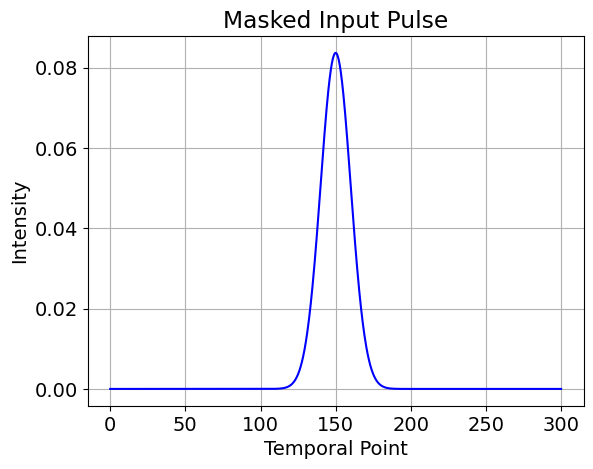

In [16]:
# plot the masked pulse
plt.plot(t, Ain.detach().numpy(), color='b')
plt.xlabel('Temporal Point')
plt.ylabel('Intensity')
plt.title('Masked Input Pulse')
plt.grid()
plt.show()

### Define Useful Functions

In [17]:
# define function to get energy form complex pulse
def get_energy(A):
    return torch.trapz(torch.abs(A)**2, t)

### Define Model and Loss Function

In [18]:
def forward(Ain):
    # apply mask
    Ain = Ain * mask
    # Perform the split-step Fourier method
    A_evolution = split_step_fourier(Ain, dz, Nz, beta2, gamma, Lt)
    iters = np.linspace(0, Nz-1, m).astype(int)
    return A_evolution[:, iters]

def loss_function(Ain, Aev):
    # for each column in Aev (of m columns), calculate the mse with the last column
    mse_loss = 0
    for i in range(m):
        mse_loss += F.mse_loss(torch.abs(Aev[:, i])**2, torch.abs(Aev[:, -1])**2)
        
    # calculate the energy loss
    energy_loss = (get_energy(Aev[:, -1]) - E_target).pow(2) # energy loss (simply square of the difference)
    
    # print("Energy loss: ", energy_loss.item(), "effective loss: ", (w_energy * energy_loss).item())
    # print("MSE loss: ", mse_loss.item(), "effective loss: ", (w_mse * mse_loss).item())
    # print("Total loss: ", w_mse * mse_loss + w_energy * energy_loss)
    
    return w_mse * mse_loss + w_energy * energy_loss
    
    # # for each column in Aev (of m columns), calculate the mse with the previous column
    # mse_loss = 0
    # for i in range(1, m):
    #     mse_loss += F.mse_loss(torch.abs(Aev[:, i])**2, torch.abs(Aev[:, i-1])**2)
    # return mse_loss
    

optimizer = optim.Adam([Ain], lr=lr)

In [19]:
# # perform test
# Aev = forward(Ain)  # full forward pass
# loss = loss_function(Ain, Aev)  # calculate the loss

### Train Model

In [20]:
losses = []


# Training loop
for iter in range(N_train):
    # clear gradients from previous step
    optimizer.zero_grad()  

    Aev = forward(Ain)  # full forward pass
    
    loss = loss_function(Ain, Aev)  # calculate the loss

    # backpropagate the loss
    loss.backward()
    
    # update the parameters
    optimizer.step()

    # save and print the loss every 100 iteration
    if iter % 10 == 0:
        losses.append(loss.item())
        if iter % 50 == 0:
            print(f"Iteration {iter}, Loss: {loss.item()}")

Iteration 0, Loss: 1.3661731372849317e-06
Iteration 50, Loss: 6.7239476209124405e-09
Iteration 100, Loss: 1.6310527373164518e-09
Iteration 150, Loss: 8.975590271020906e-10
Iteration 200, Loss: 5.212224540862564e-10
Iteration 250, Loss: 3.0268709760861157e-10
Iteration 300, Loss: 1.755343509435292e-10
Iteration 350, Loss: 1.0337996431131202e-10
Iteration 400, Loss: 6.306854344328983e-11
Iteration 450, Loss: 4.044002632763721e-11


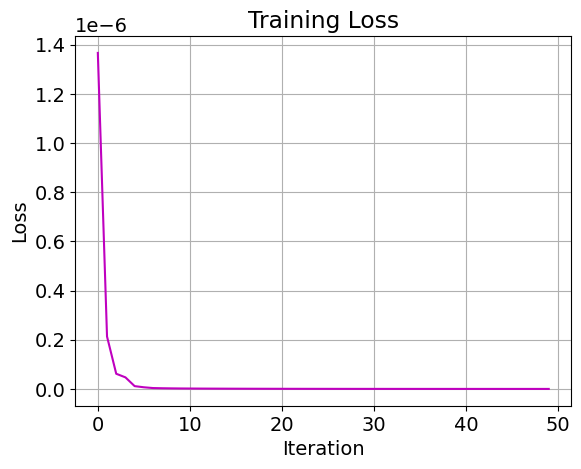

In [21]:
# plot the loss
plt.plot(losses, color='m')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid()
plt.show()

### View Results

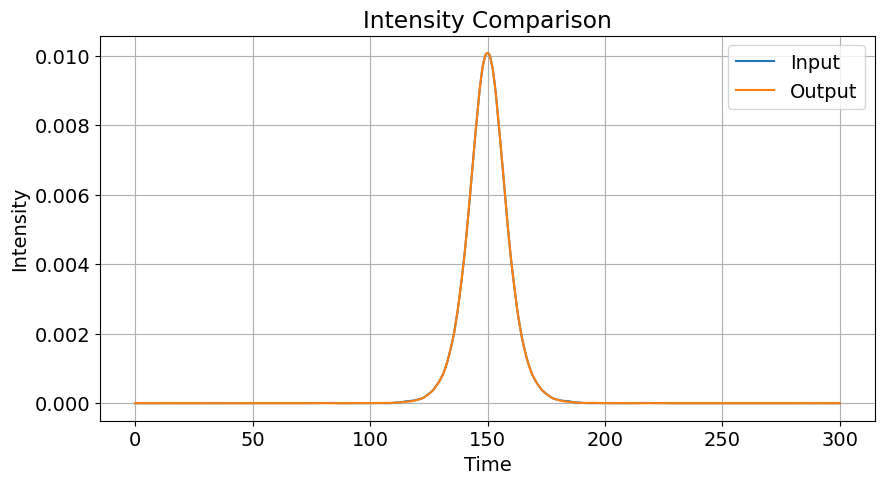

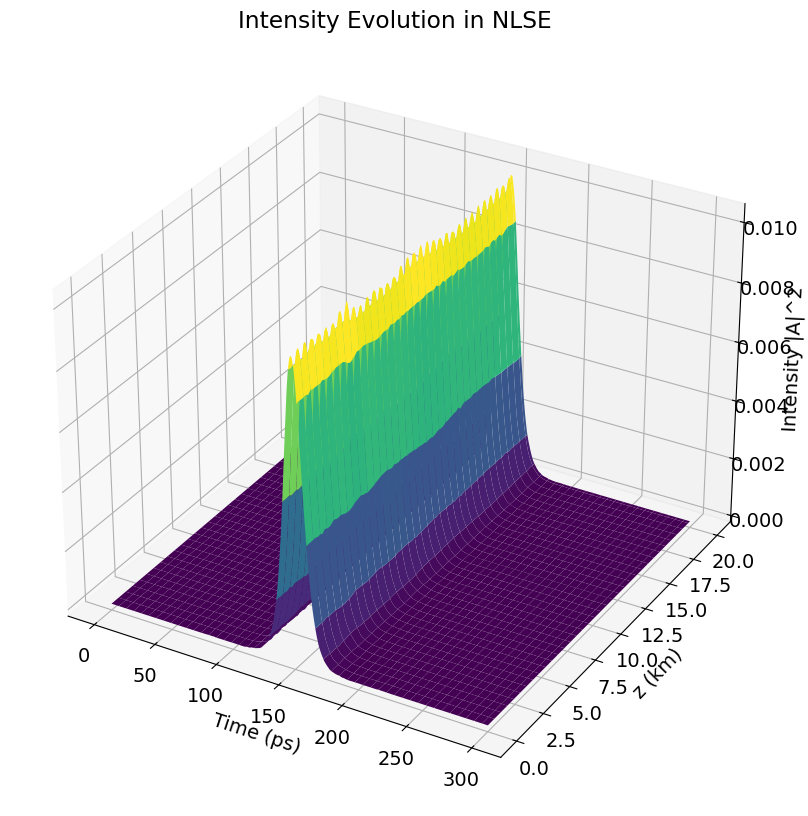

In [22]:
Aout = Aev[:, -1]
Ain_masked = Ain * mask
# plot comparison between input and output
plot_intensity_comparison(Ain_masked, Aout, t)
# plot 3D evolution
A_evolution = split_step_fourier(Ain_masked, dz, Nz, beta2, gamma, Lt)
plot_intensity_evolution(A_evolution, t, Lz, Nz)

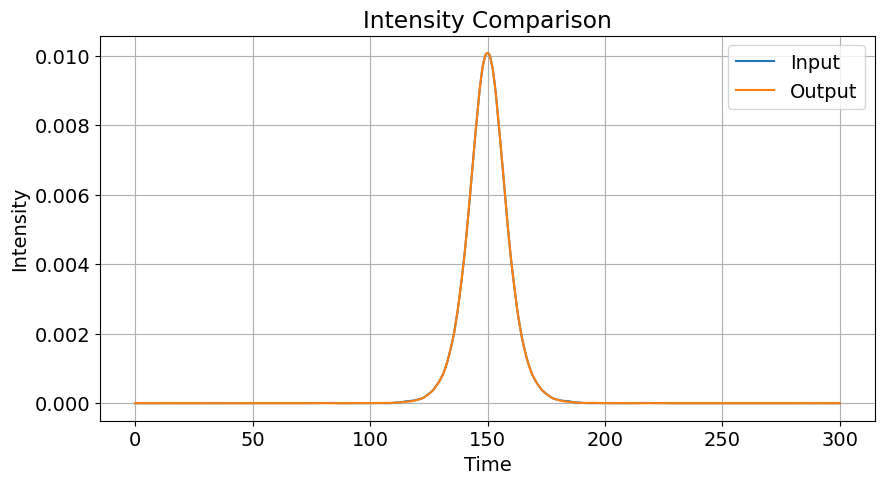

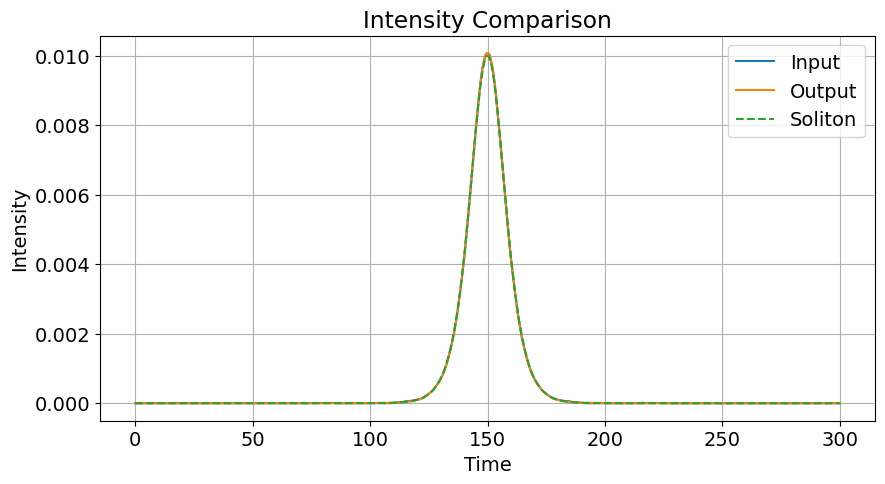

Energy of input:  0.20000378787517548
Energy of soliton:  0.20000001788139343


In [23]:
# compare to soliton
# define pulse
def sech_pulse(t, center, T0, A0):
    """Generate a Gaussian pulse."""
    return A0* 1/torch.cosh( (t-center)/ T0 + 1e-16) + 1e-16

T0 = 10.0 # optimal val
A0 = 0.1 # optimal val

A_soliton = sech_pulse(t, center, T0, A0)

# get inout and output
output = Aev[:, -1]
input = Ain * mask

# plot comparison between input and output
plot_intensity_comparison(Ain_masked, Aout, t)

"""Plot the intensity of the input and output and sech pulses for comparison."""
plt.figure(figsize=(10, 5))
plt.plot(t, torch.abs(input).detach().numpy()**2, label='Input')
plt.plot(t, torch.abs(output).detach().numpy()**2, label='Output')
plt.plot(t, torch.abs(A_soliton).detach().numpy()**2, label='Soliton', linestyle='--')
plt.title('Intensity Comparison')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.legend()
plt.grid()
plt.show()

# compare energies
E_input = get_energy(input)
E_soliton = get_energy(A_soliton)

print("Energy of input: ", E_input.item())
print("Energy of soliton: ", E_soliton.item())

## M-test: Consider variation from Soliton with snapshots

### Define Parameters

In [28]:
# define simulation parameters
Lz = 20.0               # Propagation distance in km
Nz = 100              # Number of steps in z
dz = Lz / Nz            # Step size in z
Lt = 300              # Temporal window size
Nt = 1024               # Number of temporal points

# define the training parameters
N_train = 500
lr = 1e-3
w_mse = 1.0
w_energy = 0.0001 # similar order of magnitude with this weight

# define model parameters and constraint
m = 2 # how many snapshots to compare
mask_percent = 0.25 # mask percentage
E_target = 0.20 # define the target energy (value determined based on a known reference pulse)

# define medium parameters
beta2 = -20           # Dispersion coefficient in ps^2/km
gamma = 20


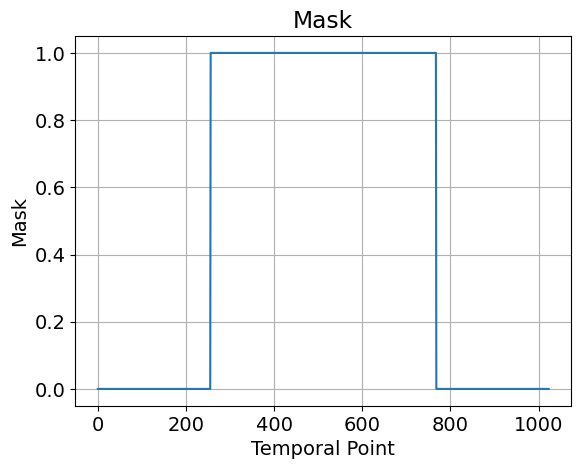

In [29]:
# set mask
mask = torch.zeros(Nt)
mask_cutoff = int(Nt * mask_percent)
mask[mask_cutoff:-mask_cutoff] = 1

# plot the mask
plt.plot(mask)
plt.xlabel('Temporal Point')
plt.ylabel('Mask')
plt.title('Mask')
plt.grid()
plt.show()


### Define Initial Guess

In [33]:
def gaussian_pulse(t, center, T0, P0):
    """Generate a Gaussian pulse using PyTorch."""
    return torch.sqrt(torch.tensor(P0)) * torch.exp(-((t - center) ** 2) / (2 * T0 ** 2))

# set Gaussian parameters
center = Lt / 2         # Center of the Gaussian pulse
T0 = 10.0             # Width of the Gaussian pulse on ps
P0 = 0.007                # sqrt of the peak power of the Gaussian pulse

# independent variable (we use torch for automatic differentiation)
t = torch.linspace(0, Lt, Nt)  # Temporal grid (only positive times)

A2in = torch.nn.Parameter(gaussian_pulse(t, center, T0, P0).clone().detach().requires_grad_(True)*mask)
A3in = torch.nn.Parameter(gaussian_pulse(t, center, T0, P0).clone().detach().requires_grad_(True)*mask)
A4in = torch.nn.Parameter(gaussian_pulse(t, center, T0, P0).clone().detach().requires_grad_(True)*mask)
A5in = torch.nn.Parameter(gaussian_pulse(t, center, T0, P0).clone().detach().requires_grad_(True)*mask)
A6in = torch.nn.Parameter(gaussian_pulse(t, center, T0, P0).clone().detach().requires_grad_(True)*mask)
A7in = torch.nn.Parameter(gaussian_pulse(t, center, T0, P0).clone().detach().requires_grad_(True)*mask)
A8in = torch.nn.Parameter(gaussian_pulse(t, center, T0, P0).clone().detach().requires_grad_(True)*mask)

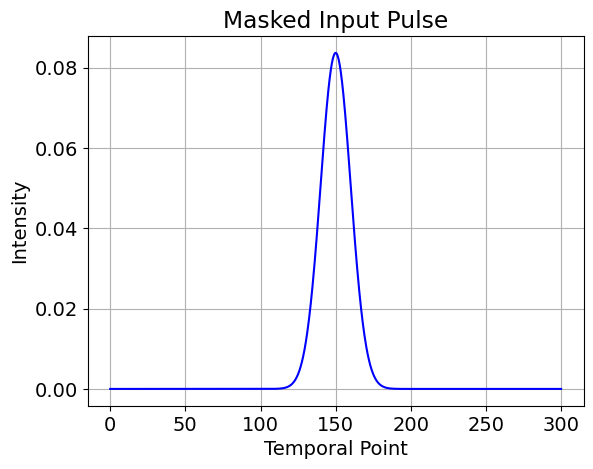

In [34]:
# plot the masked pulse
plt.plot(t, A2in.detach().numpy(), color='b')
plt.xlabel('Temporal Point')
plt.ylabel('Intensity')
plt.title('Masked Input Pulse')
plt.grid()
plt.show()

### Define Useful Functions

In [36]:
# define function to get energy form complex pulse
def get_energy(A):
    return torch.trapz(torch.abs(A)**2, t)

### Define Model and Loss Function

In [37]:
def forward(Ain):
    # apply mask
    Ain = Ain
    # Perform the split-step Fourier method
    A_evolution = split_step_fourier(Ain, dz, Nz, beta2, gamma, Lt)
    iters = np.linspace(0, Nz-1, m).astype(int)
    return A_evolution[:, iters]

def loss_function(Ain, Aev):
    # for each column in Aev (of m columns), calculate the mse with the last column
    mse_loss = 0
    for i in range(m):
        mse_loss += F.mse_loss(torch.abs(Aev[:, i])**2, torch.abs(Aev[:, -1])**2)
        
    # calculate the energy loss
    energy_loss = (get_energy(Aev[:, -1]) - E_target).pow(2) # energy loss (simply square of the difference)
    
    # print("Energy loss: ", energy_loss.item(), "effective loss: ", (w_energy * energy_loss).item())
    # print("MSE loss: ", mse_loss.item(), "effective loss: ", (w_mse * mse_loss).item())
    # print("Total loss: ", w_mse * mse_loss + w_energy * energy_loss)
    
    return w_mse * mse_loss + w_energy * energy_loss
    
    # # for each column in Aev (of m columns), calculate the mse with the previous column
    # mse_loss = 0
    # for i in range(1, m):
    #     mse_loss += F.mse_loss(torch.abs(Aev[:, i])**2, torch.abs(Aev[:, i-1])**2)
    # return mse_loss
    

optimizer2 = optim.Adam([A2in], lr=lr)
optimizer3 = optim.Adam([A3in], lr=lr)
optimizer4 = optim.Adam([A4in], lr=lr)
optimizer5 = optim.Adam([A5in], lr=lr)
optimizer6 = optim.Adam([A6in], lr=lr)
optimizer7 = optim.Adam([A7in], lr=lr)
optimizer8 = optim.Adam([A8in], lr=lr)


In [38]:
# # perform test
# Aev = forward(Ain)  # full forward pass
# loss = loss_function(Ain, Aev)  # calculate the loss

### Train Model

In [39]:
losses = []


# Training loop - do everything in parallel
for iter in range(N_train):
    # clear gradients from previous step
    optimizer2.zero_grad() 
    optimizer3.zero_grad()
    optimizer4.zero_grad()
    optimizer5.zero_grad()
    optimizer6.zero_grad()
    optimizer7.zero_grad()
    optimizer8.zero_grad()
    
    m=2
    Aev2 = forward(A2in)  # full forward pass
    loss2 = loss_function(A2in, Aev2)  # calculate the loss
    loss2.backward()
    optimizer2.step()
    
    m=3
    Aev3 = forward(A3in)  # full forward pass
    loss3 = loss_function(A3in, Aev3)  # calculate the loss
    loss3.backward()
    optimizer3.step()
    
    m=4
    Aev4 = forward(A4in)  # full forward pass
    loss4 = loss_function(A4in, Aev4)  # calculate the loss
    loss4.backward()
    optimizer4.step()
    
    m=5
    Aev5 = forward(A5in)  # full forward pass
    loss5 = loss_function(A5in, Aev5)  # calculate the loss
    loss5.backward()
    optimizer5.step()
    
    m=6
    Aev6 = forward(A6in)  # full forward pass
    loss6 = loss_function(A6in, Aev6)  # calculate the loss
    loss6.backward()
    optimizer6.step()
    
    m=7
    Aev7 = forward(A7in)  # full forward pass
    loss7 = loss_function(A7in, Aev7)  # calculate the loss
    loss7.backward()
    optimizer7.step()
    
    m=8
    Aev8 = forward(A8in)  # full forward pass
    loss8 = loss_function(A8in, Aev8)  # calculate the loss
    loss8.backward()
    optimizer8.step()

    # save and print the loss every 100 iteration
    if iter % 10 == 0:
        losses.append(loss.item())
        if iter % 50 == 0:
            #print list of losses in format (Loss 2: val, Loss 3: val, ...)
            print(f"Iteration {iter}, Loss 2: {loss2.item()}, Loss 3: {loss3.item()}, Loss 4: {loss4.item()}, Loss 5: {loss5.item()}, Loss 6: {loss6.item()}, Loss 7: {loss7.item()}, Loss 8: {loss8.item()}")
            
            

Iteration 0, Loss 2: 1.2309944850130705e-06, Loss 3: 1.3661731372849317e-06, Loss 4: 1.5849636838538572e-06, Loss 5: 1.8377147625869839e-06, Loss 6: 2.0771312847500667e-06, Loss 7: 2.2995195649855305e-06, Loss 8: 2.5366350655531278e-06
Iteration 50, Loss 2: 3.688214622599162e-09, Loss 3: 4.919935570057987e-09, Loss 4: 1.054758325125249e-08, Loss 5: 1.3140659227417473e-08, Loss 6: 1.5776864259464674e-08, Loss 7: 1.721836362378326e-08, Loss 8: 1.7833700738378866e-08
Iteration 100, Loss 2: 5.069663022716497e-10, Loss 3: 1.4518001245633627e-09, Loss 4: 1.8118264666355799e-09, Loss 5: 1.123977910744145e-09, Loss 6: 1.3267068554867478e-09, Loss 7: 1.5123294838659262e-09, Loss 8: 1.7526986528793032e-09
Iteration 150, Loss 2: 2.610778537803782e-10, Loss 3: 8.56817616856631e-10, Loss 4: 6.346279057822812e-10, Loss 5: 3.7423825149929257e-10, Loss 6: 5.223023680223093e-10, Loss 7: 4.947201537319756e-10, Loss 8: 5.653406076611134e-10
Iteration 200, Loss 2: 1.6440461492184255e-10, Loss 3: 5.4869175

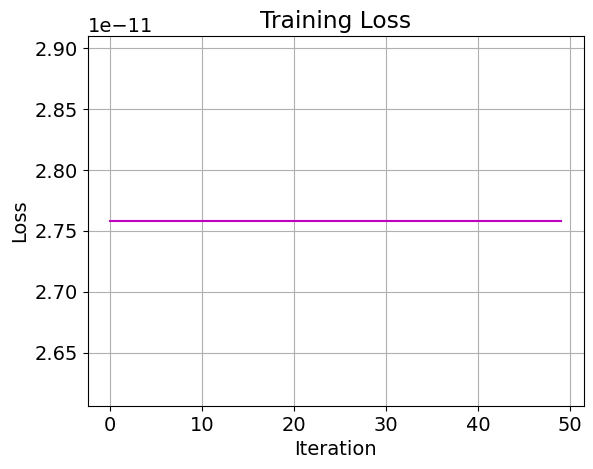

In [41]:
# plot the loss
plt.plot(losses, color='m')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid()
plt.show()

### View Results

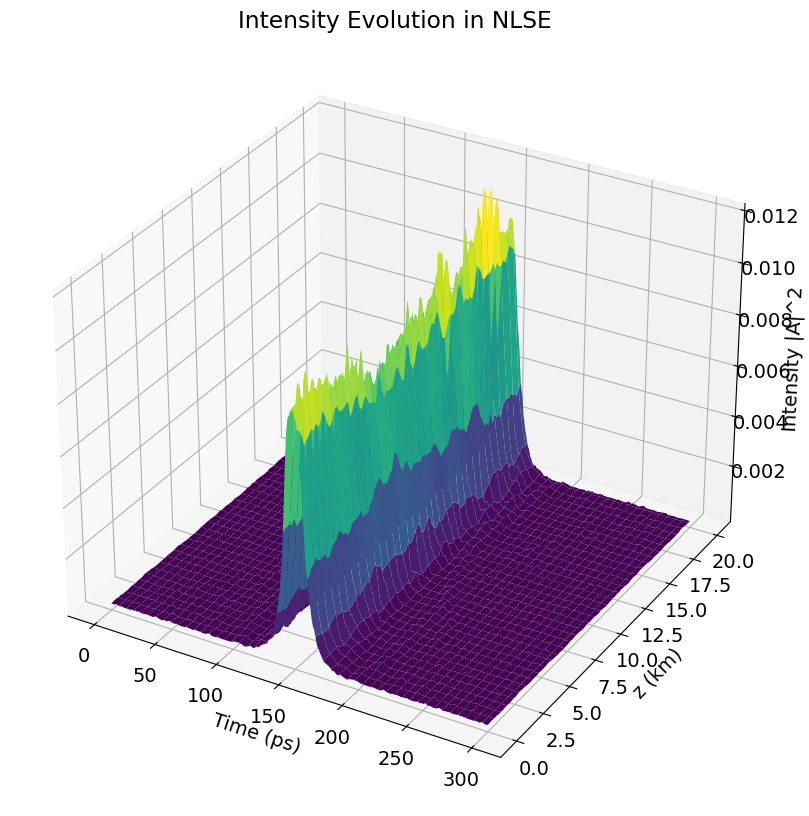

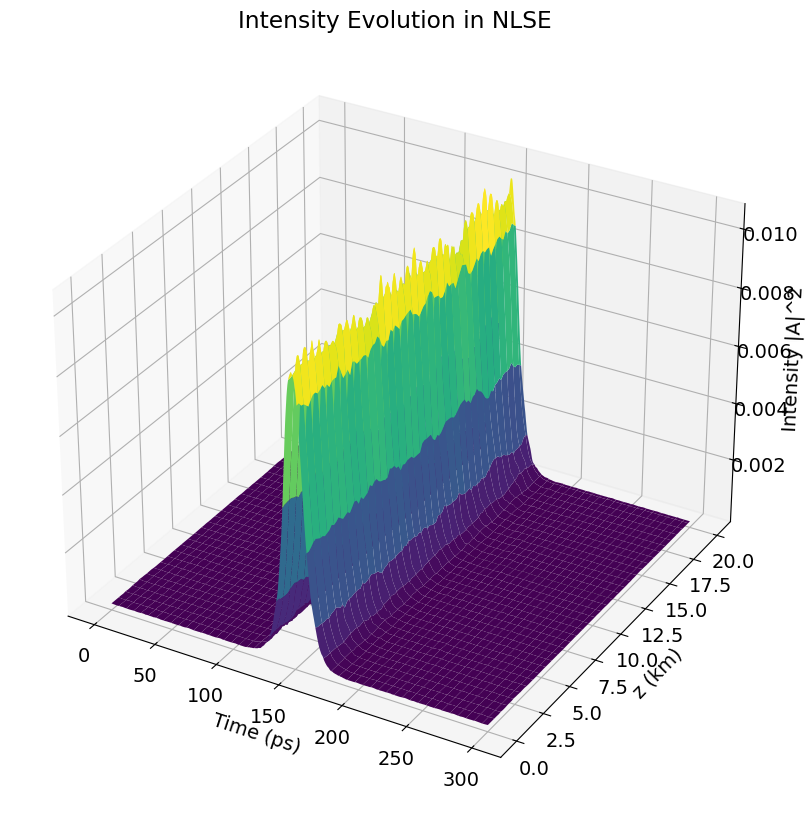

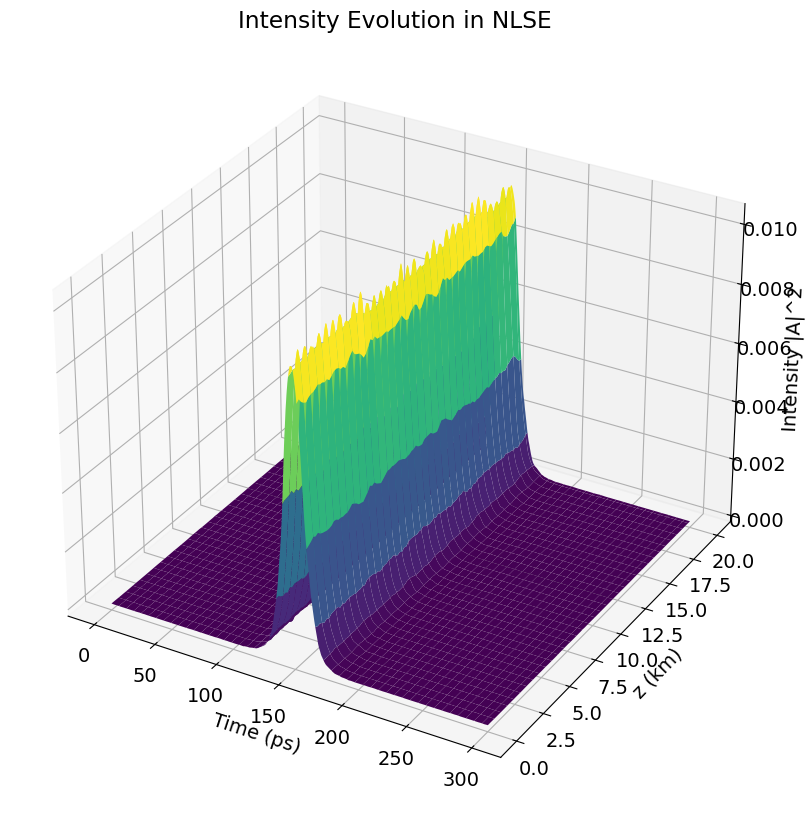

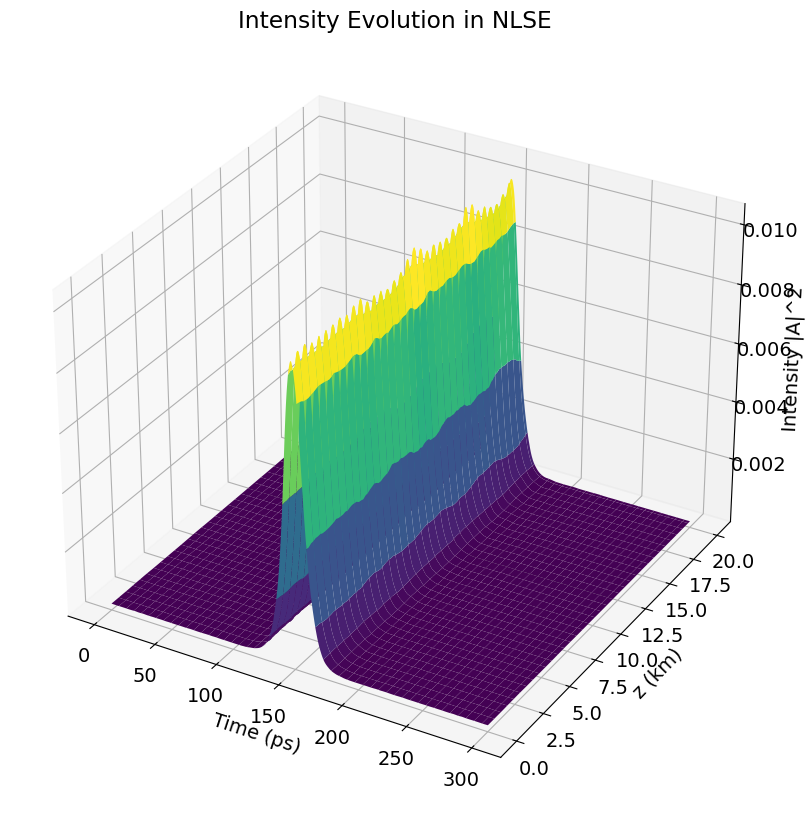

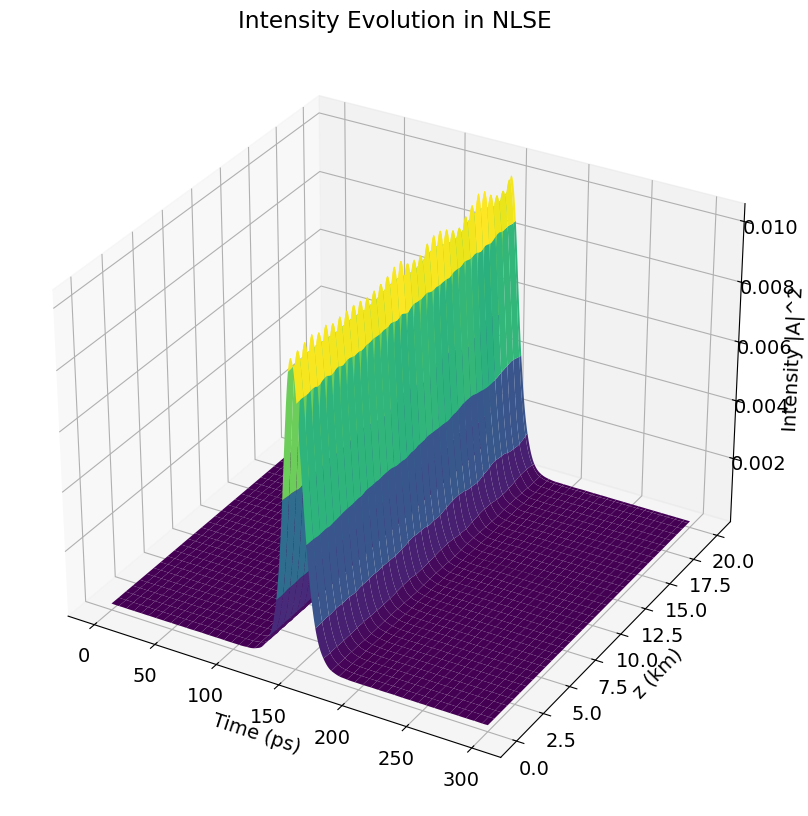

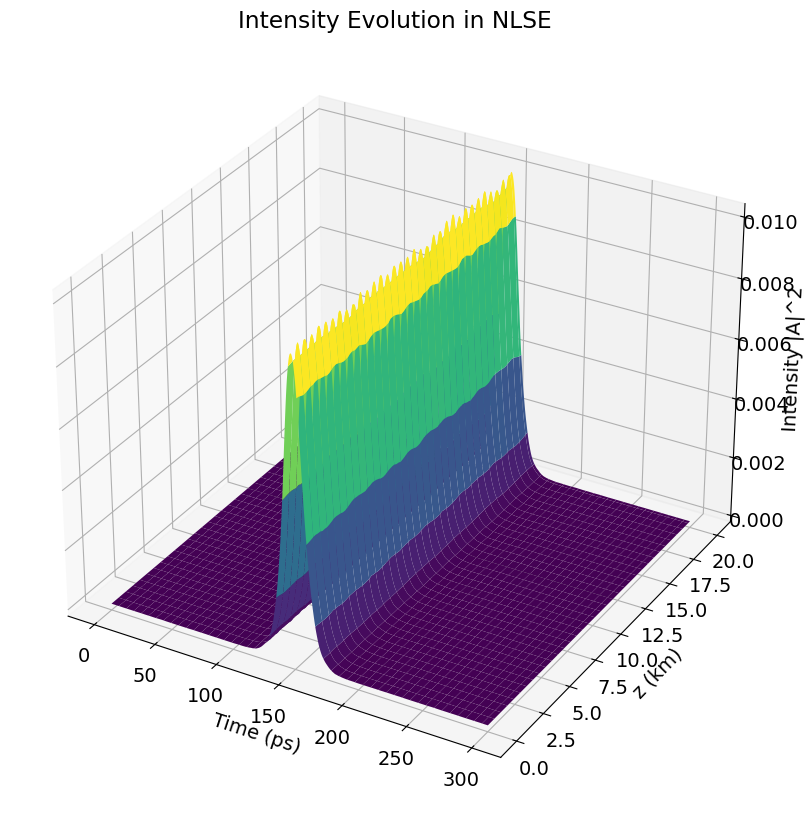

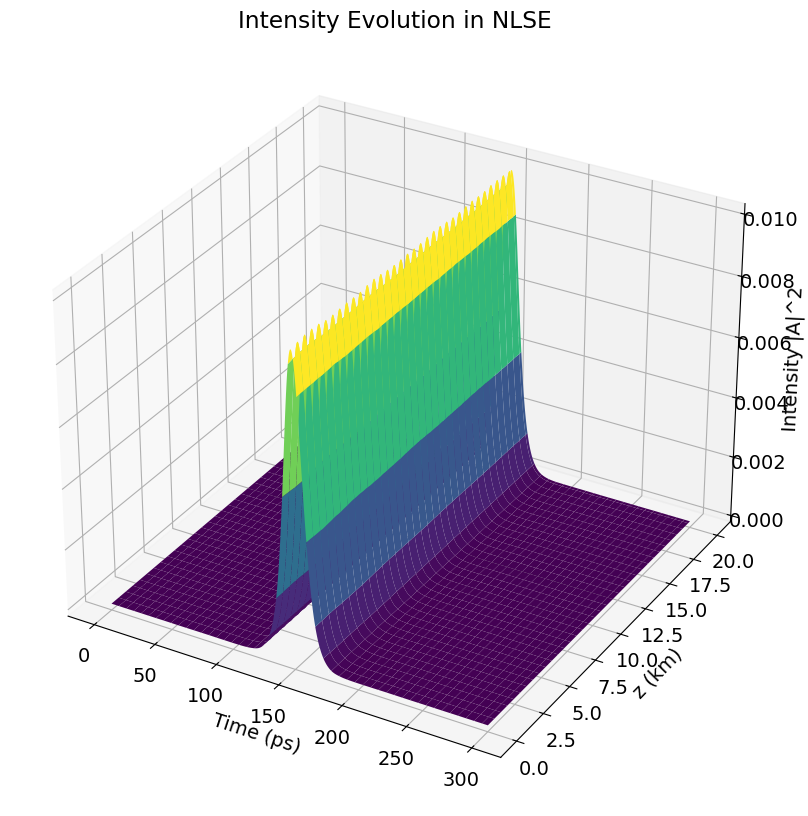

In [45]:
# get final evolutions
A2out = Aev2[:, -1]
A3out = Aev3[:, -1]
A4out = Aev4[:, -1]
A5out = Aev5[:, -1]
A6out = Aev6[:, -1]
A7out = Aev7[:, -1]
A8out = Aev8[:, -1]

# make plots of intensity evolution
A2evolution = split_step_fourier(A2in, dz, Nz, beta2, gamma, Lt)
A3evolution = split_step_fourier(A3in, dz, Nz, beta2, gamma, Lt)
A4evolution = split_step_fourier(A4in, dz, Nz, beta2, gamma, Lt)
A5evolution = split_step_fourier(A5in, dz, Nz, beta2, gamma, Lt)
A6evolution = split_step_fourier(A6in, dz, Nz, beta2, gamma, Lt)
A7evolution = split_step_fourier(A7in, dz, Nz, beta2, gamma, Lt)
A8evolution = split_step_fourier(A8in, dz, Nz, beta2, gamma, Lt)

plot_intensity_evolution(A2evolution, t, Lz, Nz)
plot_intensity_evolution(A3evolution, t, Lz, Nz)
plot_intensity_evolution(A4evolution, t, Lz, Nz)
plot_intensity_evolution(A5evolution, t, Lz, Nz)
plot_intensity_evolution(A6evolution, t, Lz, Nz)
plot_intensity_evolution(A7evolution, t, Lz, Nz)
plot_intensity_evolution(A8evolution, t, Lz, Nz)

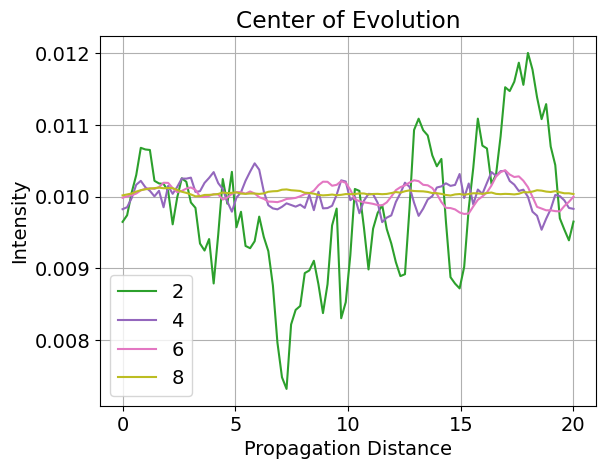

In [55]:
center2 = torch.abs(A2evolution[int(Nt/2), :])**2
center3 = torch.abs(A3evolution[int(Nt/2), :])**2
center4 = torch.abs(A4evolution[int(Nt/2), :])**2
center5 = torch.abs(A5evolution[int(Nt/2), :])**2
center6 = torch.abs(A6evolution[int(Nt/2), :])**2
center7 = torch.abs(A7evolution[int(Nt/2), :])**2
center8 = torch.abs(A8evolution[int(Nt/2), :])**2

#plot center of each evolution

z = np.linspace(0, Lz, Nz)
plt.plot(z, center2.detach().numpy()[0:100], label='2', color='C2')
#plt.plot(z, center3.detach().numpy()[0:100], label='3', color='C3')
plt.plot(z, center4.detach().numpy()[0:100], label='4', color='C4')
#plt.plot(z, center5.detach().numpy()[0:100], label='5', color='C5')
plt.plot(z, center6.detach().numpy()[0:100], label='6', color='C6')
#plt.plot(z, center7.detach().numpy()[0:100], label='7', color='C7')
plt.plot(z, center8.detach().numpy()[0:100], label='8', color='C8')
plt.legend()
plt.xlabel('Propagation Distance')
plt.ylabel('Intensity')
plt.title('Center of Evolution')
plt.grid()
plt.show()


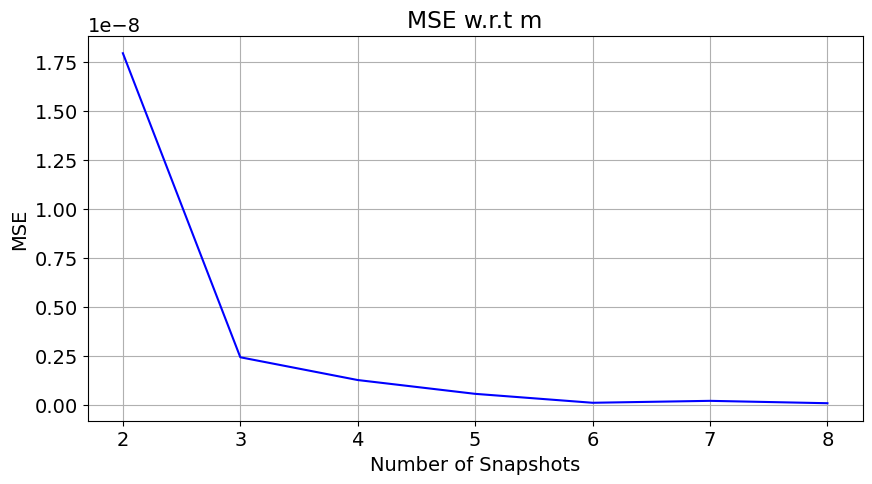

In [59]:
# compare to soliton
# define pulse
def sech_pulse(t, center, T0, A0):
    """Generate a Gaussian pulse."""
    return A0* 1/torch.cosh( (t-center)/ T0 + 1e-16) + 1e-16

T0 = 10.0 # optimal val
A0 = 0.1 # optimal val

A_soliton = sech_pulse(t, center, T0, A0)

# for each pulse 2-8 compare MSE with soliton
mse2 = F.mse_loss(torch.abs(A2out)**2, torch.abs(A_soliton)**2)
mse3 = F.mse_loss(torch.abs(A3out)**2, torch.abs(A_soliton)**2)
mse4 = F.mse_loss(torch.abs(A4out)**2, torch.abs(A_soliton)**2)
mse5 = F.mse_loss(torch.abs(A5out)**2, torch.abs(A_soliton)**2)
mse6 = F.mse_loss(torch.abs(A6out)**2, torch.abs(A_soliton)**2)
mse7 = F.mse_loss(torch.abs(A7out)**2, torch.abs(A_soliton)**2)
mse8 = F.mse_loss(torch.abs(A8out)**2, torch.abs(A_soliton)**2)
 
# plot MSE w.r.t m
plt.figure(figsize=(10, 5))
plt.plot([2,3,4,5,6,7,8], [mse2.item(), mse3.item(), mse4.item(), mse5.item(), mse6.item(), mse7.item(), mse8.item()], color='b')
plt.xlabel('Number of Snapshots')
plt.ylabel('MSE')
plt.title('MSE w.r.t m')
plt.grid()
plt.show()

